<a href="https://colab.research.google.com/github/happyhyowon/work/blob/master/HyowonKim_2019020723_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: right"> __Provided on May 14, Due on May 27__ [BRI516, Spring/2019] </div>

For homework in general:
* Install `Anaconda` and create an environment with `NumPy`, `Pandas`, `Matplotlib`, `scikit-learn` in Python 3.5 
* Please upload your jupyter-notebook file for homework to `Blackboard`
* Please visualize the results as much as possible and discuss your results at least one line of text

### [HW04]

#### Clustering Analysis (CH. 11)

##### (1) Data preparation
    Generate four isotropic Gaussian blobs with 400 2D samples and with cluster standard deviation of 0.5




### * Generate isotropic Gaussian blobs for clustering.

In [18]:
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
import numpy as np

# Generate isotropic Gaussian blobs for clustering.
X, y = make_blobs(n_samples=400, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [19]:
#help(make_blobs)

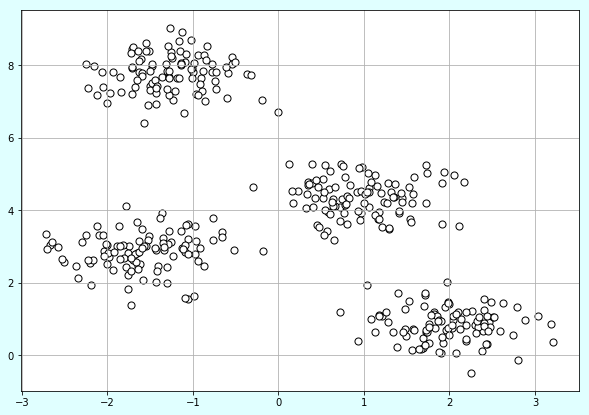

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolor='black', s=50)
plt.grid()
plt.show()

##### (2) k-means
    (2a) Implement the k-means algorithm using generic python code (i.e., not using the scikit-learn)
    (2b) Implement the `k-means++` initialization method



In [405]:
from copy import deepcopy
from scipy.spatial.distance import cdist

## (2a) Implement the k-means algorithm using generic python code (i.e., not using the scikit-learn)
class myKMeans(object):
    """K-means clustering """
    def __init__(self, n_clusters=4, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0, verbose = False):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.cluster_centers_ = np.zeros(X.shape[0])
        self.cluster_centers_old_ = np.zeros(X.shape[0])
        self.inertia_ = np.inf
        
    def fit(self, X):
        """ Compute K-means clustering 
            
            Prameters
            ---------
            X : {array-like}
            
            returns
            -------
            self : object
            
        """
        
        n = X.shape[0] # num of training data
        dim = X.shape[1] 
        
        # define variable for good center
        center_choice = np.zeros([self.n_init, self.n_clusters, dim])
        errors = np.zeros(self.n_init)
        for i_init in range(self.n_init):
            # n_init
            centers = self.get_center_init(X)
            clusters = np.zeros(n)
            clusters_new = np.zeros(n)
            pCenters = np.zeros(centers.shape) # old Center
            nCenters = deepcopy(centers) # new Center
            error = np.linalg.norm(nCenters - pCenters)
            if self.verbose == True:
                print('[init({}/{})] squared Euclidean distance : {}\n\n' .format(i_init+1,self.n_init,error))
            
            for iter in range(self.max_iter):
                # max_iter
                for i in range(n):
                    distances = np.linalg.norm((X[i] - nCenters), axis=1)
                    # minimizing within-cluster
                    cluster = np.argmin(distances)
                    # assign new cluster group about each sample
                    clusters[i] = cluster

                ## 3. Move the centroids to the center of the samples that were assigned to it.
                pCenters = deepcopy(nCenters) # update previous centers
                for i in range(self.n_clusters):
                    # get the cluster's X points from samples
                    points = [X[j] for j in range(n) if clusters[j] == i]
                    # move new mean center point
                    nCenters[i] = np.mean(points, axis=0)

                # check the lowest error
                error = np.linalg.norm(nCenters - pCenters)
                if error < self.tol:
                    break
            center_choice[i_init, :, :] = nCenters
            errors[i_init] = error
            
        # get good choice center(the loest error about n_init loop)
        self.cluster_centers_ = center_choice[np.argmin(errors), :]
        
        for i in range(n):
            distances_new = np.linalg.norm((X[i] - self.cluster_centers_), axis=1)
            cluster_new = np.argmin(distances_new)
            clusters_new[i] = cluster_new
        self.labels_ = np.array(clusters_new, dtype=np.int)
        self.inertia_ = np.sum(clusters)
        if self.verbose == True:
            print('[iter({}/{})] best cluster_centers_ : \n{}\n\n' .format(iter+1,self.max_iter,self.cluster_centers_))
                
        return self
    
    def fit_predict(self, X):        
        return self.fit(X).labels_        

    def get_center_init(self, X):
        """ Initial center generation"""
        n = X.shape[0] # num of training data
        dim = X.shape[1]        
        rgen = np.random.RandomState(self.random_state)
                
        if self.init == 'random':
            """ (2a) Implement the k-means algorithm using generic python code(default random) """
            centers = X[rgen.permutation(n)[0:self.n_clusters], :]
        
        elif self.init == 'k-means++':
            """ (2b) Implement the `k-means++` initialization method """
            center_1st = rgen.permutation(n)[0]
            centers = np.zeros([self.n_clusters,dim])
            centers[0, :] = X[center_1st, :] # set first center
            if self.verbose == True:
                print('X.shape:{} \nfirst centers : \n{}\n' .format(X.shape, centers))
            # new definde X value (except center value sample)
            newX = np.delete(X, center_1st, 0)
            if self.verbose == True:
                print('newX.shape:{} \n' .format(newX.shape))
            
            # find [n_clusters-1] centers
            for i in range(self.n_clusters - 1):
                dist = np.zeros([n-1-i, i+1])
                for j in range(i+1):
                    # calc squred euclidean distance
                    diff = np.tile(centers[j, :], [n -1 -i, 1]) - newX
                    dist[:, j] = np.sum(diff ** 2, 1)
                    
                # find the minimum squared distance &     
                # To randomly select the next centroid,  use a weighted probability distribution
                prob = np.min(dist, 1) / np.sum(np.min(dist,1))
                random_range = np.cumsum(prob)
                nIdx = np.argmax(random_range > rgen.rand(1))
                
                # update
                centers[i+1,:] = newX[nIdx,:]
                newX = np.delete(newX,nIdx,0)
            
        else:
            raise ValueError("there is no init[{}] value!!" .format(self.init))
        
        self.cluster_centers_old_ = centers
        if self.verbose == True:
            print("center_init : \n{}\n" .format(centers))

        return centers


    (2c) Run your k-means algorithm implementation using the blob dataset from (1) in the following conditions. Choose the reasonable number of runs and maximum iterations from a trial and error. 

center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(1/1)] squared Euclidean distance : 11.281002062401301


[iter(1/1)] best cluster_centers_ : 
[[-1.66609962  4.62018407]
 [ 0.92667642  2.41767033]
 [ 1.88500138  0.33770552]
 [-0.3449737   6.7648825 ]]


center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(1/1)] squared Euclidean distance : 11.281002062401301


[iter(2/2)] best cluster_centers_ : 
[[-1.47428603  3.13581575]
 [ 0.80220324  3.71331164]
 [ 2.01298386  0.78640615]
 [-0.99221684  7.42235289]]


center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(1/1)] squared Euclidean distance : 11.281002062401301


[iter(3/3)] best cluster_centers_ : 
[[-1.61355662  2.85985205]
 [ 0.94349757  4.34329532]
 [ 1.97306689  0.84915787]
 [-1.26551713  7.7693112 

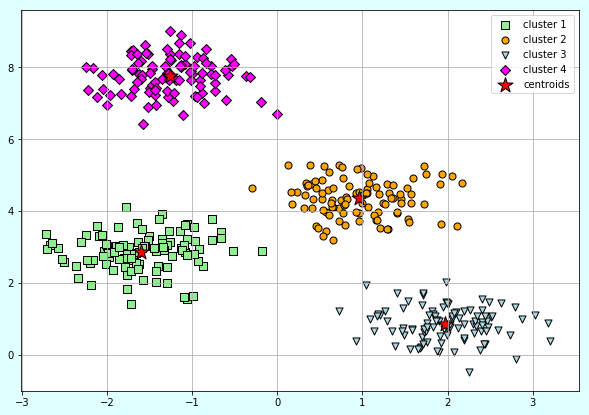

In [406]:
mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=1, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=2, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=3, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=4, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=5, verbose=True)
y_mykm = mykm.fit_predict(X)

# Plotting along with the Centroids
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[y_mykm == 0, 0], X[y_mykm == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_mykm == 1, 0], X[y_mykm == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_mykm == 2, 0], X[y_mykm == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_mykm == 3, 0], X[y_mykm == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(mykm.cluster_centers_[:, 0], mykm.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(1/1)] squared Euclidean distance : 11.281002062401301


[iter(1/1)] best cluster_centers_ : 
[[-1.66609962  4.62018407]
 [ 0.92667642  2.41767033]
 [ 1.88500138  0.33770552]
 [-0.3449737   6.7648825 ]]


center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(1/2)] squared Euclidean distance : 11.281002062401301


center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(2/2)] squared Euclidean distance : 11.281002062401301


[iter(1/1)] best cluster_centers_ : 
[[-1.66609962  4.62018407]
 [ 0.92667642  2.41767033]
 [ 1.88500138  0.33770552]
 [-0.3449737   6.7648825 ]]


center_init : 
[[-1.71462623  7.20392584]
 [ 2.52119171  1.06764615]
 [ 2.37692475  0.11235196]
 [-0.91002541  7.64445554]]

[init(1/3)] square

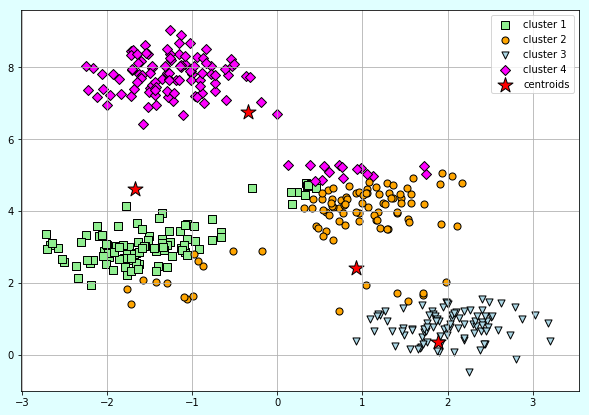

In [407]:
mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=1, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 2, max_iter=1, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 3, max_iter=1, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 4, max_iter=1, verbose=True)
y_mykm = mykm.fit_predict(X)

mykm = myKMeans(n_clusters=4, init='random', n_init = 5, max_iter=1, verbose=True)
y_mykm = mykm.fit_predict(X)

# Plotting along with the Centroids
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[y_mykm == 0, 0], X[y_mykm == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_mykm == 1, 0], X[y_mykm == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_mykm == 2, 0], X[y_mykm == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_mykm == 3, 0], X[y_mykm == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(mykm.cluster_centers_[:, 0], mykm.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

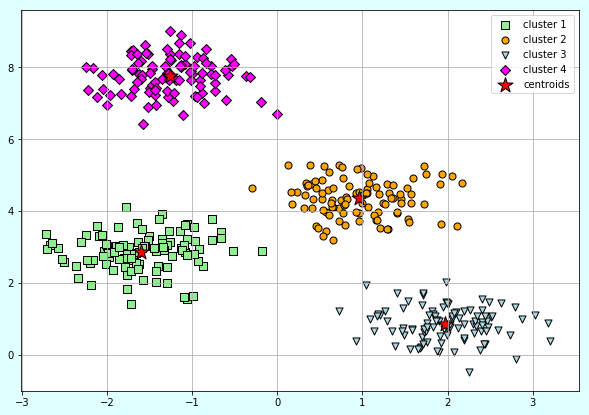

In [408]:
mykm = myKMeans(n_clusters=4, init='random', n_init = 1, max_iter=5, verbose=False)
y_mykm = mykm.fit_predict(X)

# Plotting along with the Centroids
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[y_mykm == 0, 0], X[y_mykm == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_mykm == 1, 0], X[y_mykm == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_mykm == 2, 0], X[y_mykm == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_mykm == 3, 0], X[y_mykm == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(mykm.cluster_centers_[:, 0], mykm.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

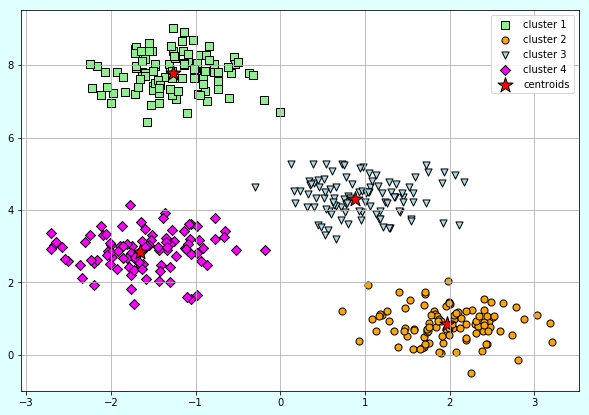

In [409]:
mykm = myKMeans(n_clusters=4, init='k-means++', n_init = 1, max_iter=1, verbose=False)
y_mykm = mykm.fit_predict(X)

# Plotting along with the Centroids
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[y_mykm == 0, 0], X[y_mykm == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_mykm == 1, 0], X[y_mykm == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_mykm == 2, 0], X[y_mykm == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_mykm == 3, 0], X[y_mykm == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(mykm.cluster_centers_[:, 0], mykm.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

* 현재 자료에서는 n_init은 1번 n_maxiter도 5번 정도면 충분히 잘 실행되어 보인다. 만일 k-mean++로 한다면 둘다 1회만 해도 잘 실행되고 있다.

    (2c-1) Choose an optimal number of clusters between 1 and 10 based on both the elbow method and silhouette method

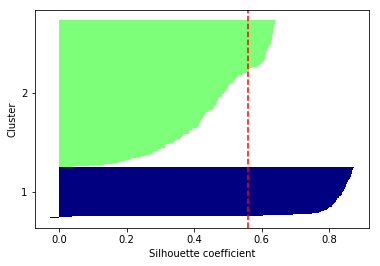

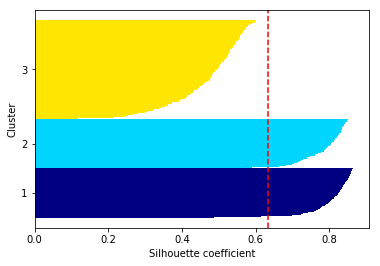

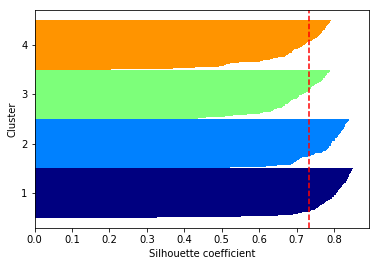

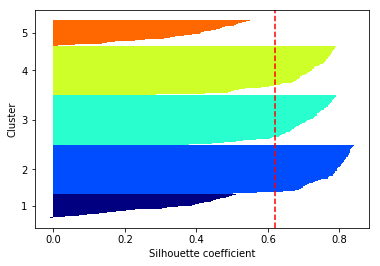

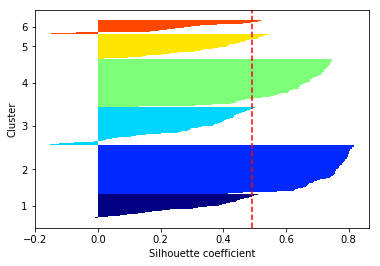

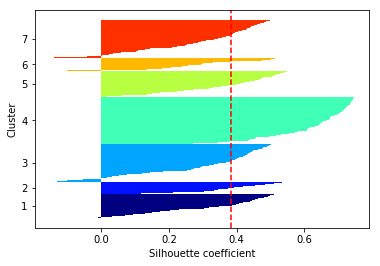

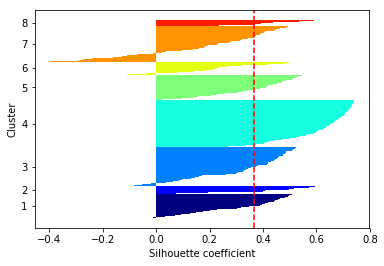

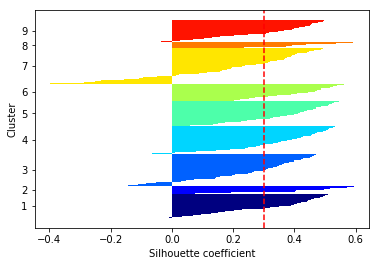

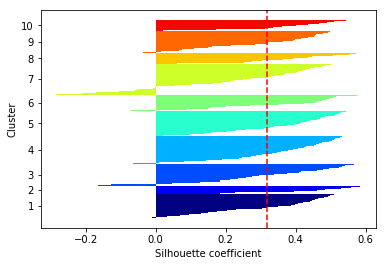

In [411]:
# import silhouette plots
from matplotlib import cm
from sklearn.metrics import silhouette_samples

# silhouette method
for i in range(2, 11):
    km = myKMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

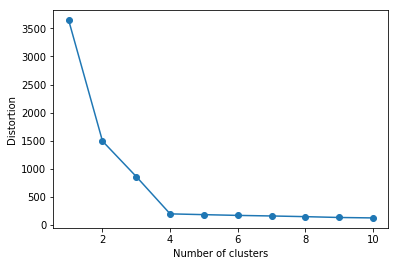

In [412]:
# elbow method
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

* n_cluser가 4일 경우에 가장 적합한 결과를 도출해 낼수 있다.

    (2c-2) Set the optimal number of cluseters found from (2c-1) and compare the results of clustering analysis 

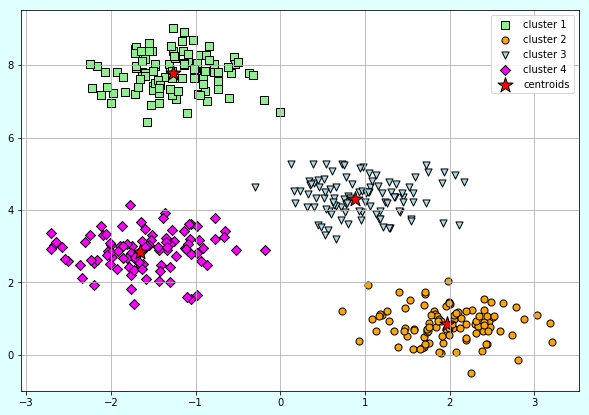

In [367]:
mykm = myKMeans(n_clusters=4, init='k-means++', n_init = 1, max_iter=1, verbose=False)
y_mykm = mykm.fit_predict(X)

# Plotting along with the Centroids
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[y_mykm == 0, 0], X[y_mykm == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_mykm == 1, 0], X[y_mykm == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_mykm == 2, 0], X[y_mykm == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_mykm == 3, 0], X[y_mykm == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(mykm.cluster_centers_[:, 0], mykm.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

* 예상한대로 적합한 cluster를 한것을 확인할수 있었다.

    (2c-3) Compare the results of your implementation and results of the scikit-learn implementation for both (2c-1) and (2c-2)

### * results of the scikit-learn implementation

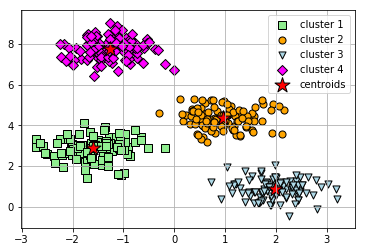

In [125]:
# the scikit-learn implementation

km = KMeans(n_clusters=4, init='random', n_init=1, max_iter=100, tol=1e-04, random_state=0, verbose=False)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_km == 3, 0], X[y_km == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

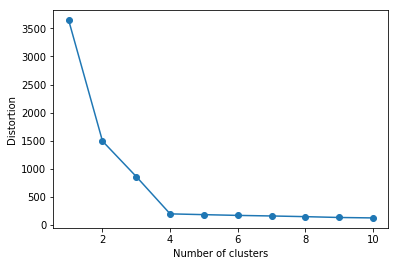

In [370]:
# elbow method
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

* Cluster number 4 is good choice because as we can see in the following plot, the elbow is located at number 4, which is evidence that number 4 is indeed a good choice for this dataset.

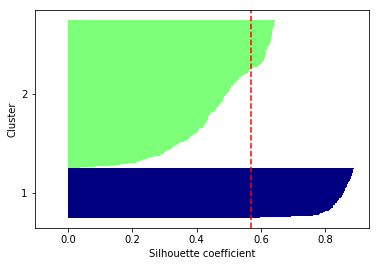

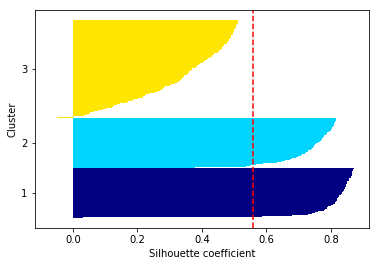

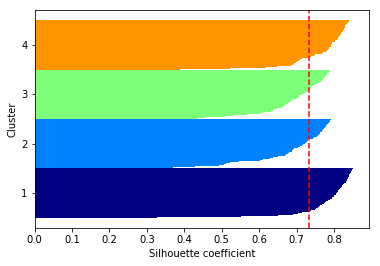

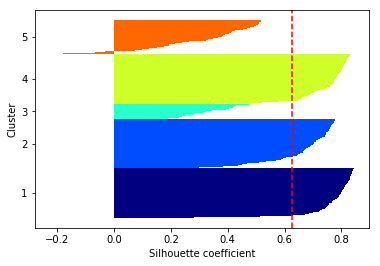

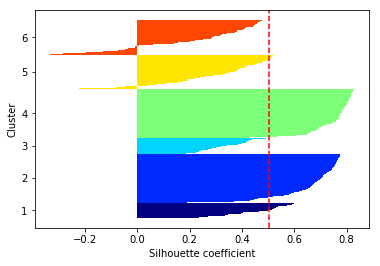

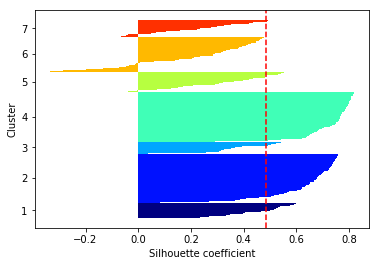

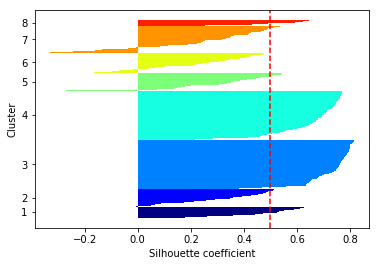

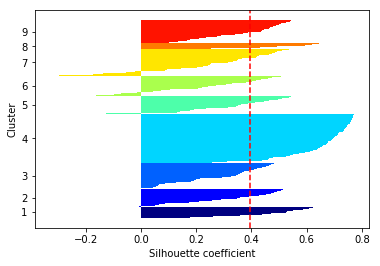

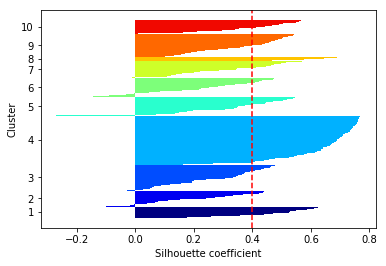

In [11]:
# silhouette method
for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

* Cluster number 4 is good choice because not only width and length are the similar each of them but also coefficients are not even close to 0.
* 직접 구현한 결과와 별반 다르지 않음을 알수 있다.

##### (3) Fuzzy C-means (FCM)
    (3a) Implement the FCM using generic python code

In [377]:
## (2a) Implement the k-means algorithm using generic python code (i.e., not using the scikit-learn)
class myFCM(object):
    """ Fuzzy C KMean Algorithm """
    def __init__(self, n_clusters=4, fuzzy_coef_m = 2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0, verbose = False):
        self.n_clusters = n_clusters
        self.fuzzy_coef_m = fuzzy_coef_m
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.cluster_centers_ = np.zeros(X.shape[0])
        self.cluster_centers_old_ = np.zeros(X.shape[0])
        self.inertia_ = np.inf
        
    def fit(self, X):       
        n = X.shape[0] # num of training data
        dim = X.shape[1] 
        
        # define variable for good center
        center_choice = np.zeros([self.n_init, self.n_clusters, dim])
        errors = np.zeros(self.n_init)
        for i_init in range(self.n_init):
            # n_init
            centers = self.get_center_init(X)
            clusters_new = np.zeros(n)
            
            for iter in range(self.max_iter):
                # max_iter
                dist = np.zeros([n, self.n_clusters])
                for i in range(self.n_clusters):
                    diff = np.tile(centers[i,:],[n,1]) - X
                    dist[:,i] = np.sum(diff**2,1)**0.5
                    
                # euclidean distance를 기반으로 w 값 계산
                labels = np.zeros([n,self.n_clusters])
                
                # add very small value when dis is 0.
                dist = dist + 0.000001
                    
                for i in range(self.n_clusters):
                    labels[:,i] = np.sum((np.tile(dist[:,i].reshape([-1,1]),[1,self.n_clusters]) / dist) ** (2/(self.fuzzy_coef_m-1)),1)
                
                labels = labels ** -1
                
                # check the lowest error
                error = np.mean(np.mean(dist,1))
                if error < self.tol:
                    break
                
                for i in range(self.n_clusters):
                    centers[i, :] = np.sum(X * np.tile((labels[:, i]).reshape([-1, 1]), [1, dim]),0) / np.sum((labels[:, i]))
                        
            center_choice[i_init, :, :] = centers
            errors[i_init] = error
            
        # get good choice center(the loest error about n_init loop)
        self.cluster_centers_ = center_choice[np.argmin(errors), :]
        self.labels_ = labels #np.array(clusters_new, dtype=np.int)
        self.inertia_ = np.sum(labels * dist)
        
        if self.verbose == True:
            print('[iter({}/{})] best cluster_centers_ : \n{}\n\n' .format(iter+1,self.max_iter,self.cluster_centers_))
                
        return self
    
    def fit_predict(self, X):        
        return self.fit(X).labels_        

    def get_center_init(self, X):
        """ Initial center generation"""
        n = X.shape[0] # num of training data
        dim = X.shape[1]        
        rgen = np.random.RandomState(self.random_state)
                
        if self.init == 'random':
            """ (2a) Implement the k-means algorithm using generic python code(default random) """
            centers = X[rgen.permutation(n)[0:self.n_clusters], :]
        
        elif self.init == 'k-means++':
            """ (2b) Implement the `k-means++` initialization method """
            center_1st = rgen.permutation(n)[0]
            centers = np.zeros([self.n_clusters,dim])
            centers[0, :] = X[center_1st, :] # set first center
            if self.verbose == True:
                print('X.shape:{} \nfirst centers : \n{}\n' .format(X.shape, centers))
            # new definde X value (except center value sample)
            newX = np.delete(X, center_1st, 0)
            if self.verbose == True:
                print('newX.shape:{} \n' .format(newX.shape))
            
            # find [n_clusters-1] centers
            for i in range(self.n_clusters - 1):
                dist = np.zeros([n-1-i, i+1])
                for j in range(i+1):
                    # calc euclidean distance
                    diff = np.tile(centers[j, :], [n -1 -i, 1]) - newX
                    dist[:, j] = np.sum(diff ** 2, 1)
                    
                # find the minimum squared distance &     
                # To randomly select the next centroid,  use a weighted probability distribution
                prob = np.min(dist, 1) / np.sum(np.min(dist,1))
                random_range = np.cumsum(prob)
                nIdx = np.argmax(random_range > rgen.rand(1))
                
                # update
                centers[i+1,:] = newX[nIdx,:]
                newX = np.delete(newX,nIdx,0)
            
        else:
            raise ValueError("there is no init[{}] value!!" .format(self.init))
        
        self.cluster_centers_old_ = centers
        if self.verbose == True:
            print("center_init : \n{}\n" .format(centers))

        return centers


In [378]:
myfcm = myFCM(n_clusters=4, fuzzy_coef_m=2, init='k-means++', tol=1e-10, verbose=False)
y_myfcm = myfcm.fit_predict(X)

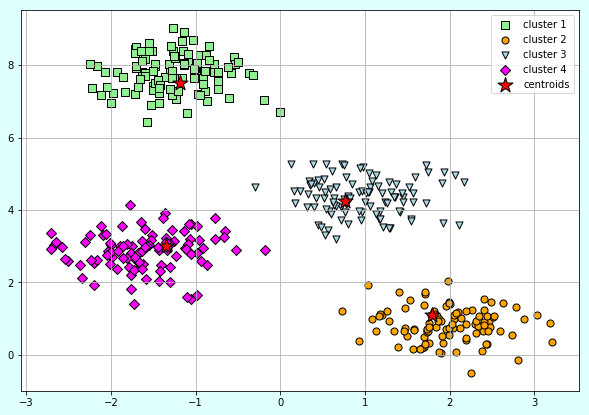

In [379]:
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[y_myfcm[:, 0] > 0.4, 0], X[y_myfcm[:, 0] > 0.4, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_myfcm[:, 1] > 0.4, 0], X[y_myfcm[:, 1] > 0.4, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_myfcm[:, 2] > 0.4, 0], X[y_myfcm[:, 2] > 0.4, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_myfcm[:, 3] > 0.4, 0], X[y_myfcm[:, 3] > 0.4, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(myfcm.cluster_centers_[:, 0], myfcm.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

    (3b) Let's suppose the fuzziness coefficient, m = 2. Choose the proper number of clusters between 1 and 10 based on the elbow method 

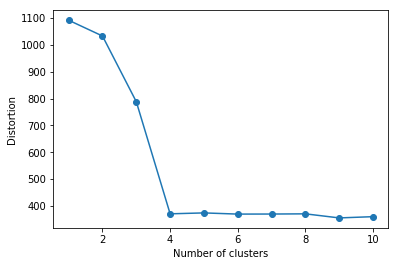

In [381]:
# elbow method
distortions = []
for i in range(1, 11):
    km = myFCM(n_clusters=i, fuzzy_coef_m=2, init='k-means++', tol=1e-10, verbose=False)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

    (3c) Discuss the obtained results with the results from (2c-1)

* 실제 KMeans가 FCM보다 더 잘 clustering되는거 같아 보인다.